In [1]:
import temul.api as tml
import atomap.api as am
import hyperspy.api as hs
import numpy as np
import os

if "data" not in os.path.abspath(''):
    path_to_data = os.path.join(os.path.abspath(''), "data") 
    os.chdir(path_to_data)


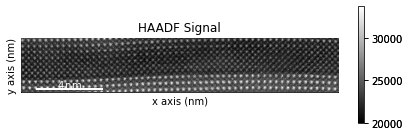

In [2]:
# Open the PTO/SRO dataset

image = hs.load('Cropped_PTO-SRO_Aligned.hspy')
sampling = image.axes_manager[-1].scale #  nm/pix
units = image.axes_manager[-1].units
image.plot()


In [3]:
''' Find the atom positions.The difference in intensity between PTO and SRO can
cause issues, so you can use hyperspy to just crop the SRO layer or use the
atomap atom picker. If you don't want to, you can just load the data as shown
below. '''

just_load_the_data = True

if just_load_the_data:
    atom_positions1 = np.load('atom_positions1.npy')
else:
    atom_positions1 = am.get_atom_positions(image, separation=10, pca=True)
    atom_positions1 = am.add_atoms_with_gui(image, atom_positions1)


Gaussian fitting:   0%|          | 0/465 [00:00<?, ?it/s]

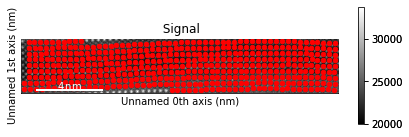

In [4]:
sublattice1 = am.Sublattice(atom_positions1, image, color='red')
sublattice1.find_nearest_neighbors()
sublattice1.refine_atom_positions_using_2d_gaussian(percent_to_nn=0.25)
sublattice1.construct_zone_axes(atom_plane_tolerance=1)
sublattice1.plot()

In [5]:
# Find sublattice2 using sublattice1

atom_plane_dir = sublattice1.zones_axis_average_distances[3]

atom_positions2 = sublattice1.find_missing_atoms_from_zone_vector(
    atom_plane_dir, vector_fraction=0.5)


Gaussian fitting:   0%|          | 0/404 [00:00<?, ?it/s]

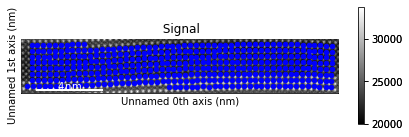

In [6]:
sublattice2 = am.Sublattice(atom_positions2, image, color='blue')
sublattice2.find_nearest_neighbors()
sublattice2.refine_atom_positions_using_2d_gaussian(percent_to_nn=0.25)
sublattice2.construct_zone_axes(atom_plane_tolerance=1)
sublattice2.plot()


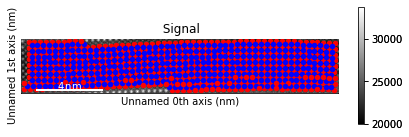

In [7]:
# Make and save the Atom Lattice

atom_lattice = am.Atom_Lattice(image, name='PTO-SRO-cropped-region',
                               sublattice_list=[sublattice1, sublattice2])
# atom_lattice.save(filename="Atom_Lattice_crop_new.hdf5")
atom_lattice.plot()

In [8]:
# Set up parameters for calculate_atom_plane_curvature

zone_vector_index = 0
atom_planes = (2, 6) #  chooses the starting and ending atom planes
vmin, vmax = 1, 2
cmap = 'bwr' #  see matplotlib and colorcet for more colormaps
title = 'Curvature Map'
filename = None #  Set to a string if you want to save the map

In [9]:
# Set the extra initial fitting parameters

p0 = [14, 10, 24, 173]
kwargs = {'p0': p0, 'maxfev': 1000}

In [10]:
# We want to see the curvature in the SRO Sublattice

curvature_map = tml.calculate_atom_plane_curvature(sublattice2, zone_vector_index, title=title,
                    sampling=sampling, units=units, cmap=cmap, **kwargs)

In [11]:
# We want to see the curvature in just the SRO Region

curvature_map = tml.calculate_atom_plane_curvature(sublattice2, zone_vector_index, title=title,
                    sampling=sampling, units=units, cmap=cmap, **kwargs,
                    atom_planes=atom_planes)

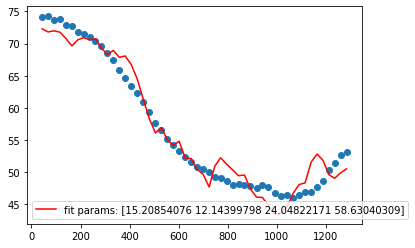

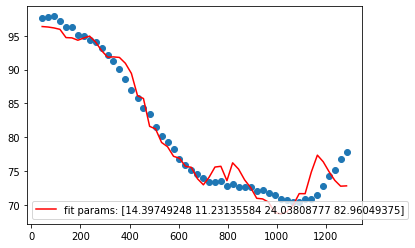

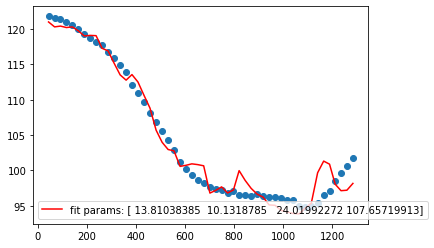

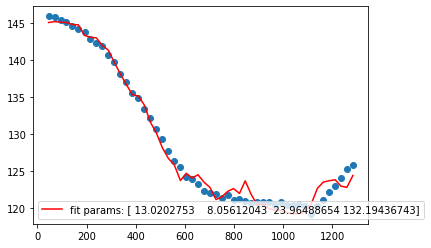

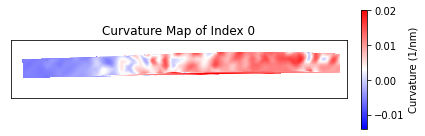

In [12]:
# When using plot_and_return_fits=True, the function will return the curve
#   fittings, and plot each plane.

curvature_map, fittings = tml.calculate_atom_plane_curvature(sublattice2, zone_vector_index,
                    sampling=sampling, units=units, cmap=cmap, title=title,
                    atom_planes=atom_planes, plot=True, return_fits=True, **kwargs)